# Starbucks Capstone Project

## Overview

This project looks at the data simulated by Starbucks customers to look at their spending habbits in relation to different promotions that they have been sent. There are three different datasets to look at:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - UNKNOWN
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Goals

1. Get an overview overview of the Starbucks population
    - What is the gender distribution?
    - What is the income distribution?
    - When do people typically become a member?
    - What is the average purchase distribution?
    
    
    
2. How do people react to different promotions?
    - Do people react to different promotions differently?
    - Does the reward of the promotion make people react differently?
    - Does it make sense to offer certain rewards?
        - Would starbucks save money overall if they offer a certain reward?
 
 
 
3. How well does a machine learning algorithm cluster the groups of users together?
    - How many number of clusters should Starbucks use
        - 2 Clusters? (BOGO and Discount customers?)
        - 5 Clusters? (2 BOGOS, 3 Discount deals?)
    

## Step 1: Data Loading and Cleanup

In [2]:
# Import python libraries and data
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
% matplotlib inline
import seaborn as sns

In [3]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Going through each dataframe, here are the updates that need to be made:

* Transcripts:
    - The value column needs has two different items: value type and value
        - Should be two different columns: value and value_type
 
* Profile:
    - Make sure there are no duplications
    - became_member_on should be converted to date and not string
        - can also break into year, month, day
    - Fill NULL values for gender and income values
        - gender is a categorical variable, so you can fill Gender with "U" for Unknown
        - income needs to be filled with value that is apropriate with income distributions
    
* Portfolio: 
    - Make channels a bit flag for any type
    - Make sure ther are no duplicates

## Portfolio cleanup

In [7]:
available_channels = []

# Look to see what are all of the different channels
for channel in portfolio['channels']:
    for t in channel:
        if t not in available_channels:
            available_channels.append(t)
            
available_channels

['email', 'mobile', 'social', 'web']

In [8]:
# Add in the email, mobile, social, and web columns
for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

portfolio.drop('channels', axis = 1, inplace=True) # No longer need the channels column

# Make Sure all of the int and float columns are correct
cols_to_update = ['difficulty', 'duration','reward']

for col in cols_to_update:
    portfolio[col] = portfolio[col].apply(lambda x: int(x))


portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [9]:
# Make sure that each row is unique
len(np.unique(portfolio['id'])) == len(portfolio)

True

## Transcript cleanup

In [10]:
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) # First value is the value_type
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) # Second value is the new value

# Make sure that the time value is an integer amount
transcript['time'] = transcript['time'].apply(lambda x: int(x))

transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


## Profile cleanup

In [11]:
# For Gender, instead of assuming a gender, lets just make the gender Unknown
profile['gender'].fillna('U', inplace = True)
profile['income'] = profile['income'].apply(lambda x: float(x))
profile['age'] = profile['age'].apply(lambda x: int(x))

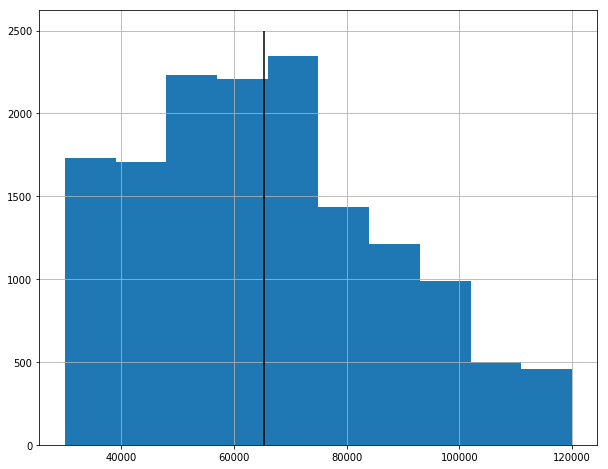

In [12]:
# What should be filled in for the null 
# The mean looks like it would be apropraiate in this distribution
profile.income.hist(bins=10, figsize=(10,8));
plt.vlines(profile.income.mean(), 0, 2500); # Show where the mean is in the 

In [13]:
mean_val = profile.income.mean() # 65404.99
profile['income'].fillna(mean_val, inplace = True)

In [14]:
# Converting became_member_on to an actual date number and also creating more
# columns based on the year, month, daay for further analysis
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)

In [15]:
profile.head()

,age,gender,id,income,member_year,member_month,member_day,member_date
0,118,U,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,118,U,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,118,U,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


# Exploratory Analysis

## Gender Analysis

Roughly half of the people in the Starbucks population are males, while females, unknown, and other genders make up the rest of the population. When looking at the mean income of each gender, they aren't very different from each other, but looking at their distirubtions tell a different story. Unknown genders don't have a distribution to look at since they were all replaced with the mean income of the overall poopulation. Females have most of their users with incomes between 55,000 dollars to 90,000 dollars while males upper quartile of users have roughly the same income as the mean value for female customers, roughly 60,000 dollars

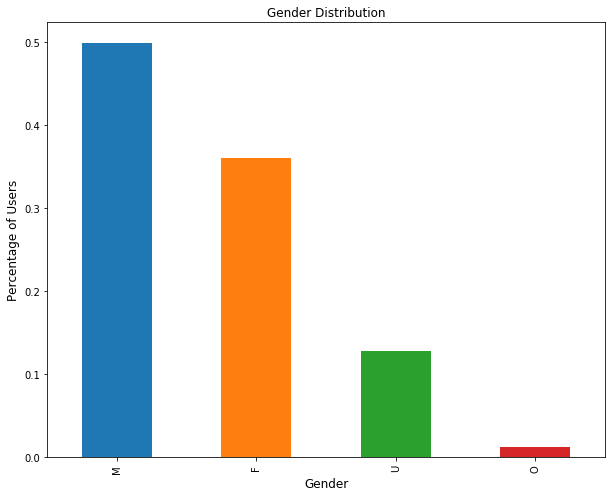

In [16]:
profile.gender.value_counts(normalize=True).plot('bar', figsize = (10,8))
plt.title('Gender Distribution')
plt.ylabel('Percentage of Users', fontsize = 12)
plt.xlabel('Gender', fontsize = 12);

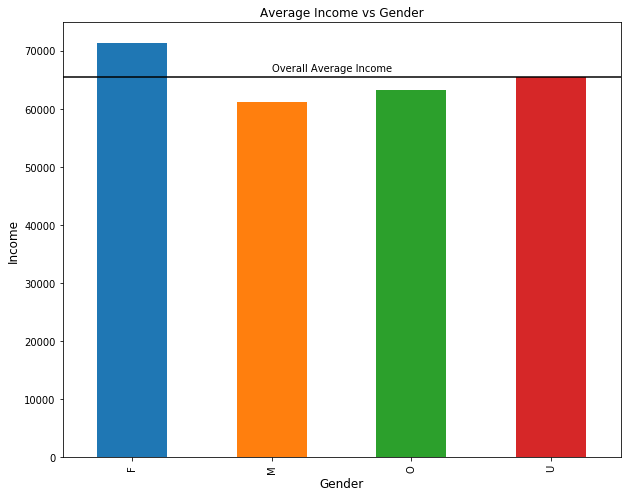

In [17]:
gender_income = profile.groupby('gender', as_index=False).agg({'income':'mean'})
gender_income.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(10,8))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Average Income vs Gender')
plt.text(1, mean_val + 1000, 'Overall Average Income'); 

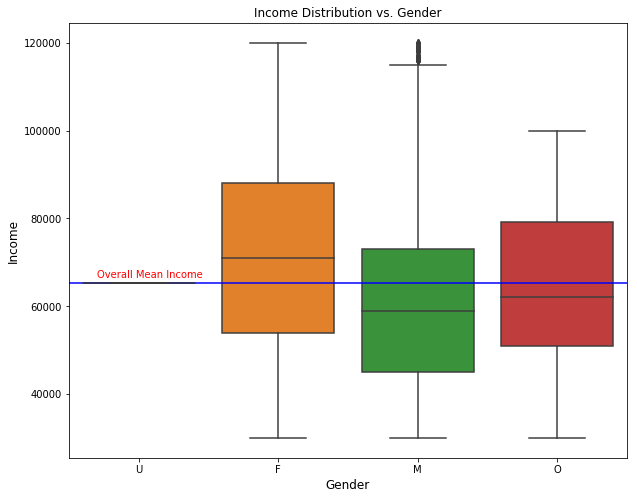

In [18]:
plt.figure(figsize=(10,8))
sns.boxplot(x = 'gender', y = 'income', data = profile)
plt.hlines(mean_val, -100 , 1000, color = 'b')
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Income Distribution vs. Gender')
plt.text(x = -.3, y = mean_val + 1000, s = "Overall Mean Income", color = 'r');

# Customer Sign Ups

It is interesting to look at the days that customers signed up. You can see that there are 3 distinct points in time where there is a large increase in customer sign ups and then it seems to stay pretty consistent for a while after that. There was a significant decrease right around the start of 2018, which is an interesting point. 

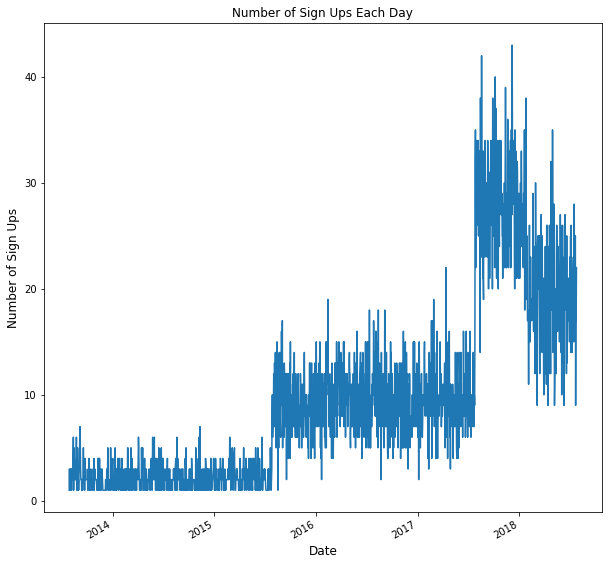

In [19]:
# Number of sign ups each day
profile.member_date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

We can also look at custoer subscriptions by month. It looks like in every year, subscriptions drop at the beginning of the year and then have a significant uprise right around July. I wonder if that is because people are signing up for their fall specials since that is around the time that the fall drinks go on display. Maybe the promotions are based around the fall drinks?

One interesting thing to point is is that in even years, subsciptions seem to stay pretty constant, but in odd years, there are big jumps. Maybe there are new app releases in those years?

2018 also seems to be having a rough year. The summer months have had a big decrease in customer sign ups as opposes to the rate from previous years.

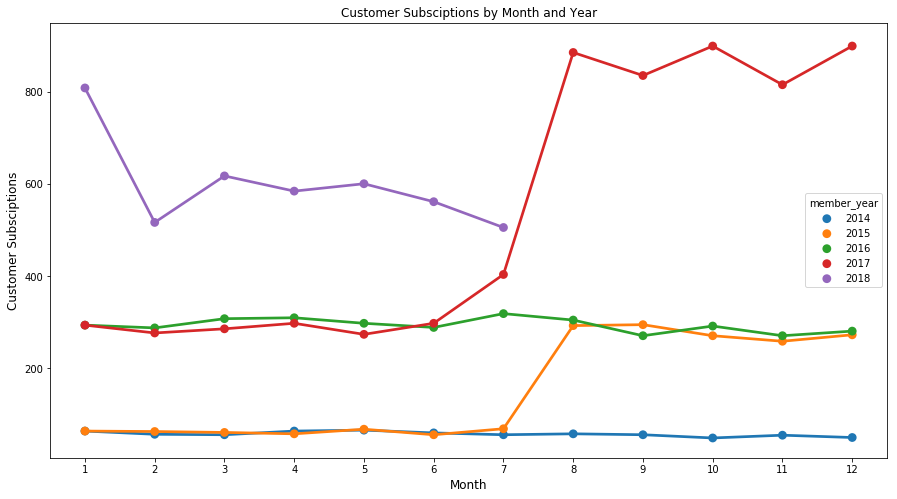

In [20]:
membership_subs = profile[profile['member_year'] >= 2014].groupby(['member_year','member_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="member_month", y="id", hue="member_year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Customer Subsciptions by Month and Year');

# Customer Transactions

My walkthrough of the customer transactions table took me in all different directions. There are two different types of value_types to look for: amount, which is the purchase amount for that specific transaction, and offer id, which is offer that came through. The offer id can have the offer recieved, offer reviewed, and the offer compelted. 

In [21]:
# This specific one is a discount offer that was recieved, viewed, and completed all on the same day
transcript[(transcript['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f') 
           & (transcript['value'] == '2906b810c7d4411798c6938adc9daaa5')]

,event,person,time,value,value_type
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer id
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer id
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer_id


In [22]:
# The different events that come through are mostly transactions, then apropriately the offers recieved, 
# offers viewed, and offers completed.
transcript['event'].value_counts(normalize = True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [23]:
# Looking at all of the completed offers, discounts and bogos are roughly a 50/50 split. 
trans_and_offers = pd.merge(transcript[(transcript['value_type'] == 'offer_id') & (transcript['event'] == 'offer completed')]
                            , portfolio, how = 'inner', left_on = 'value', right_on = 'id')
trans_and_offers['offer_type'].value_counts(normalize = True)

discount    0.533369
bogo        0.466631
Name: offer_type, dtype: float64

# Data Analysis

## Offer Type Analysis

There are plenty of things that can be viewed in the process of a customer's transactions. If we can get the order of all of the transactions, then we can get an understanding of purchase trends and which offers were completed. 

First, let's just look at one person's transaction amounts. We can get the average value amount and days between purchases. 

In [24]:
# All amount transactions of a random person
test_person_transactions = transcript[(transcript['person'] == '8dbfa485249f409aa223a2130f40634a')
          & (transcript['value_type'] == 'amount')].reset_index()
# Get the difference of days between purchases
test_person_transactions['DaysFromLastPurchase'] = test_person_transactions.time.diff()

# The first value needs to be the same as the first transaction time inseat of NULL
test_person_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

# Need to set values as an float

test_person_transactions['value'] = test_person_transactions['value'].apply(lambda x: float(x))

# Don't need the reset index column anymore
test_person_transactions.drop('index', axis = 1, inplace = True)
test_person_transactions.head(10)

,event,person,time,value,value_type,DaysFromLastPurchase
0,transaction,8dbfa485249f409aa223a2130f40634a,6,3.86,amount,6.0
1,transaction,8dbfa485249f409aa223a2130f40634a,30,0.88,amount,24.0
2,transaction,8dbfa485249f409aa223a2130f40634a,36,2.86,amount,6.0
3,transaction,8dbfa485249f409aa223a2130f40634a,54,0.17,amount,18.0
4,transaction,8dbfa485249f409aa223a2130f40634a,78,1.02,amount,24.0
5,transaction,8dbfa485249f409aa223a2130f40634a,84,0.49,amount,6.0
6,transaction,8dbfa485249f409aa223a2130f40634a,108,1.72,amount,24.0
7,transaction,8dbfa485249f409aa223a2130f40634a,186,1.66,amount,78.0
8,transaction,8dbfa485249f409aa223a2130f40634a,192,0.61,amount,6.0
9,transaction,8dbfa485249f409aa223a2130f40634a,228,1.31,amount,36.0


In [25]:
# Now we can aggregate the values to get the average transaction amount, average days between purchases,
# and how long that they have been a customer
test_person_transactions.groupby('person').agg({
                                                'value':'mean' #Average transaction Amount
                                               , 'DaysFromLastPurchase':'mean' #Average days between purchases
                                                , 'time':'max' # How long they have been a Starbucks member
                                               })

,value,DaysFromLastPurchase,time
person,,,
8dbfa485249f409aa223a2130f40634a,2.123889,18.833333,678


# Promotion activity

What about how customers react with different promotions? What we would want to see is what promotions the customer recieved and which ones he completed for that specific promotion type

In [26]:
# Want to look at recieved transactions and completed transactions
test_completion = pd.merge(
                    transcript[transcript['event'] == 'offer received']
                    , transcript[transcript['event'] == 'offer completed']
                    , how = 'left'
                    , left_on = ['person','value']
                    , right_on = ['person','value']
        )

# Make sure that the time values are converted to floats / integers
test_completion['time_y'] = test_completion['time_y'].apply(lambda x: float(x))
test_completion['time_x'] = test_completion['time_x'].apply(lambda x: float(x))


In [27]:
test_completion.head()

,event_x,person,time_x,value,value_type_x,event_y,time_y,value_type_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id,offer completed,132.0,offer_id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,offer id,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,offer id,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id,NaN,NaN,NaN


Now that we have the joins for the person and the offer id, there are some double joins since one person can recieve the same offer it multiple times. We only want the offers that line up correctly in the same time frame.

In [44]:
completion = test_completion[
    (
        (test_completion['time_y'] <= (test_completion['time_x'] + 20)) # Completion date is within max time frame
        & (test_completion['time_y'] >= test_completion['time_x'])  # Completion date is after offer received
    )
    
    | # or 
    
    (pd.isnull(test_completion['event_y']) == True) # Null values to show offers that were never completed
        ][['person','time_x','value','event_y','time_y']]

completion['DaysToCompleteOffer'] = completion['time_y'] - completion['time_x'] 
completion['CompletedOffer'] = completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
completion.tail()

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
86425,f924927e7f844ecebf87eef93f4d2688,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1
86431,e4052622e5ba45a8b96b59aba68cf068,576.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,0


Looking at the same test person as before, they might have a lot of transactions but they recieved two offers and didnt complete either one. 

In [45]:
completion[completion['person'] == '8dbfa485249f409aa223a2130f40634a']

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
5765,8dbfa485249f409aa223a2130f40634a,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0
63399,8dbfa485249f409aa223a2130f40634a,504.0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,0


Let's look at a person that has completed some offers

In [46]:
# We can see that this person completed both 
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366']

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
57550,9dc1421481194dcd9400aec7c9ae6366,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,414.0,6.0,1
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1


In [47]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366'].groupby('person').agg({
    
    'time_x':'min' # When they recieved their first offer
    , 'CompletedOffer': 'mean' # Percentage of Completed Offers
    , 'DaysToCompleteOffer': 'mean' # Average time it takes to complete an offer
})

,time_x,CompletedOffer,DaysToCompleteOffer
person,,,
9dc1421481194dcd9400aec7c9ae6366,408.0,1,12.0


## Does the type of offer determine if if someone will complete it and how long it will take to complete?

Since we have the offers that people received and whether they completed it or not, we can now see if there is a trend with what offers are being completed the most and other statistics about it

In [48]:
# Bring together the completed / non completed offers and what type of offer they were
offers_final_df = pd.merge(completion
         ,portfolio
         , how = 'inner'
         , left_on = 'value'
         , right_on = 'id'
        )[['person','time_x','value','CompletedOffer','DaysToCompleteOffer'
          , 'difficulty','duration','offer_type','reward','email','mobile','social','web'
          ]]
offers_final_df.columns = ['person','offer_time','value','CompletedOffer','DaysToCompleteOffer'
                          ,'difficulty','duration','offer_type','reward'
                          , 'email','mobile','social','web'
                        ]
offers_final_df['NetReward'] = offers_final_df['reward'] - offers_final_df['difficulty']
offers_final_df.tail()

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
48845,db1805ed333844978e8b46ed3e4643ae,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48846,eec70ab28af74a22a4aeb889c0317944,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48847,31e915c24163436790b97c1d45b545f6,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48848,361539b15a6243dc834c6b25e481570b,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48849,eb7dd979f4644052a5c401a01f129132,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0


You can see that the lower the difficulty, the more likely someone is going to complete the reward. The informational offer type means nothing in this section, it will be helpful for looking at other individual statistics for individuals. 

Looking at the discounts, you can see that even though the net reward is better for Starbucks, it doesn't necessarily mean that they will make the most expected money. The NetWorth column shows how much Starbucks makes from that offer by multiplying the probability of someone actually using that coupon shows that the best coupon is the $2 if you spend $10. That will get an expected reward back of 2.23, while the other offers make roughly 1.50

In [90]:
overall_offers_df = offers_final_df.groupby(['offer_type','difficulty','reward'], as_index = False).agg({
    'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

overall_offers_df.columns.droplevel(1)
overall_offers_df.columns = ['offer_type','difficulty','reward','CompletedOffers','TotalCompletions'
                            , 'AvgDaysToComplete','NetReward']
overall_offers_df['NetWorth'] = (overall_offers_df['CompletedOffers'] * overall_offers_df['NetReward']) * -1
final_overall_offers_df = overall_offers_df[overall_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToComplete,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


When we are comparing better methods of whether a customer should be given a BOGO or Discount, we can reference the net worth of this dataframe.

# Individual metrics

To get our clusters together, we now need to bring all of the above metrics at an individual level. 

In [52]:
all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,value,value_type
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,amount
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,amount
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,amount
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,amount
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,amount


In [54]:
df_all_customers = pd.DataFrame(columns = ['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases'])

for person in np.unique(profile['id']):
    
    # Get Individual profile info
    personal_profile = profile[profile['id'] == person][['id','age','gender','income','member_date']]
    
    # Get transaction aggregates
    personal_transactions = all_transactions[all_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        personal_transactions['DaysFromLastPurchase'] = personal_transactions.time.diff()
        personal_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

        personal_agg_trans = personal_transactions.groupby('person', as_index = False).agg(
        {
            'time': ['count','min','max'] # First and Last Purchase
            , 'value': ['mean', 'sum'] # Average Purchase Amount, total purchase amount
            , 'DaysFromLastPurchase': ['median', 'mean'] # Average days between purchases  
        })
        personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1) # Gets rid of the multi leveling columns
        personal_agg_trans.columns = ['person', 'total_transactions','min_transaction_day','max_transaction_day'
                                      , 'avg_transaction','total_transaction_amount','median_days_between_purchases'
                                      ,'avg_days_between_purchases']
    else:
        null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        personal_agg_trans = pd.DataFrame([null_array]
                                         , columns = ['person', 'total_transactions','min_transaction_day'
                                                      ,'max_transaction_day'
                                                      , 'avg_transaction','median_days_between_purchases'
                                                      ,'avg_days_between_purchases'])
        
        
    # Bring together the transaction aggregates and the profile values
    personal_df_1 = pd.merge(personal_profile, personal_agg_trans
                             , how = 'inner', left_on = 'id', right_on = 'person')
    personal_df_1.drop('id', axis = 1, inplace = True) # Get rid of the ID column
    
    
    # Look at the different promotions that the person interacted with
    # Using global variables to join data in the next step
    for offer_type in ['discount','bogo']:
        globals()[offer_type + '_df'] =  offers_final_df[(offers_final_df['person'] == person)
                       & (offers_final_df['offer_type'] == offer_type)
                       ].groupby('person', as_index = False).agg({
                                                        'CompletedOffer':['count','mean','sum']
                                                        , 'DaysToCompleteOffer': ['min','max','mean']
                                                        , 'NetReward': ['mean']
                                                    })
        
        globals()[offer_type + '_df'].columns = globals()[offer_type + '_df'].columns.droplevel(1)
        globals()[offer_type + '_df'].columns = ['person', offer_type + '_total_offers'
                                    ,offer_type + '_completion_pct', offer_type + '_completed_offers'
                                   , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
                                    ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']
        
        if len(globals()[offer_type + '_df']) == 0:
            null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
            globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
                dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
            )
    
    # Bring together the bogo and discount values, and include the number of informational promos they received
    bogo_and_discounts = pd.merge(discount_df, bogo_df)
    bogo_and_discounts['informational_promotions'] = len(offers_final_df[(offers_final_df['person'] == person)
                                                               & (offers_final_df['offer_type'] == 'informational')])
    
    # Bring everything together
    person_final = pd.merge(bogo_and_discounts, personal_df_1)
    
    # Add personal df to the rest of the customer dataframe
    df_all_customers = df_all_customers.append(person_final)
        

In [55]:
# Make sure that there are the same number of people in the all customers dataframe are in the #
# profile database
len(df_all_customers) == len(profile)

True

In [56]:
# Just to get the columns in the order that I would like
df_all_customers = df_all_customers[['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']]

In [57]:
df_all_customers.head(10)

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,gender,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,M,72000.000000,2017-04-21,8,228,696,15.950000,127.60,27.0,59.250000
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,U,65404.991568,2018-04-25,3,294,474,1.363333,4.09,18.0,62.000000
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,O,57000.000000,2018-01-09,5,132,654,15.892000,79.46,66.0,105.600000
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,F,90000.000000,2016-03-04,8,54,708,24.607500,196.86,21.0,82.500000
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,60000.000000,2016-11-11,12,42,672,12.837500,154.05,30.0,53.000000
0,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,73000.000000,2017-06-21,18,66,696,2.685556,48.34,21.0,35.333333
0,00426fe3ffde4c6b9cb9ad6d077a13ea,3,0,NaN,NaN,0,NaN,-10.3333,NaN,NaN,...,F,65000.000000,2016-08-09,17,36,696,4.030000,68.51,18.0,39.176471
0,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,74000.000000,2018-05-08,6,18,714,23.060000,138.36,90.0,117.000000
0,004c5799adbf42868b9cff0396190900,1,1,0.0,0.0,1,0.0,-8,1,1,...,M,99000.000000,2016-03-31,12,222,690,28.948333,347.38,27.0,39.500000
0,005500a7188546ff8a767329a2f7c76a,1,0,NaN,NaN,0,NaN,-8,3,0,...,M,47000.000000,2017-12-09,4,204,588,5.090000,20.36,33.0,97.500000


# Final Analysis

Now that we have each customer in a dataframe with all of their personal characteristics, transactional aggregates, and promotional aggregates, one way that we can improve on correct promotional affiliation is to see how that specific cluster responds to different promotions. 

We want to take all of the attributes that can be used to cluster customers and fill their null values with 0's because those columns show that the customer didn't participate in that category. We also need to make gender a dummy vairable since it is the only true categorical variable.

I decided to use the AgglomerativeClustering clustering algorithm because it tries to minimize the clustering distance from each other, and the ward linkage paramter minimizes the variance of the clusters being merged, which I belive is the best option as opposed to finding the average distance from each cluster center.

I used 4 clusters because you can ideally fall into 4 different types of peole who react to promotions:

1. Use both BOGO and Discounts
2. Dont use either BOGO or Discounts
3. Favor BOGO over Discount
4. Favor Discount over BOGO

In [58]:
from sklearn import cluster

In [59]:
clust = cluster.AgglomerativeClustering(4, linkage='ward')

# Want to create new dataframe that only takes the features that should be examined. The only feature that would be
# useless to include would be the person ID
# We also want to fill any values that are NULl with 0. This is apropriate because the values that could be NULL
# is if the customer never participated in it

X = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']].fillna(0)

# Gender is the only true categorical variable, so we need to make a dummy value for it
new_x = pd.get_dummies(data=X, columns=['gender'])

# Set the Cluster 4 column with the cluster predictions of the clustering algorithm
df_all_customers['Cluster_4'] = clust.fit_predict(new_x)

In [60]:
df_all_customers.head()

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases,Cluster_4
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,72000.000000,2017-04-21,8,228,696,15.950000,127.60,27.0,59.25,2
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,65404.991568,2018-04-25,3,294,474,1.363333,4.09,18.0,62.00,2
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57000.000000,2018-01-09,5,132,654,15.892000,79.46,66.0,105.60,1
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,90000.000000,2016-03-04,8,54,708,24.607500,196.86,21.0,82.50,0
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.000000,2016-11-11,12,42,672,12.837500,154.05,30.0,53.00,1


Now that we have associated a cluster to each person, let's see what the breakdown of these clusters are and what key attributes each cluster shows

In [114]:
# Looks like cluster 2 has the most people, and cluster 3 has the least amount of people.
df_all_customers.Cluster_4.value_counts(normalize = True)

2    0.334941
1    0.260647
0    0.256176
3    0.148235
Name: Cluster_4, dtype: float64

We should first looka at a seaborn pairplot to look at distributions of each cluster and how they cross compare to other features. This first graph looks at more personal attributes like age, gender, income, and avg transaction amount

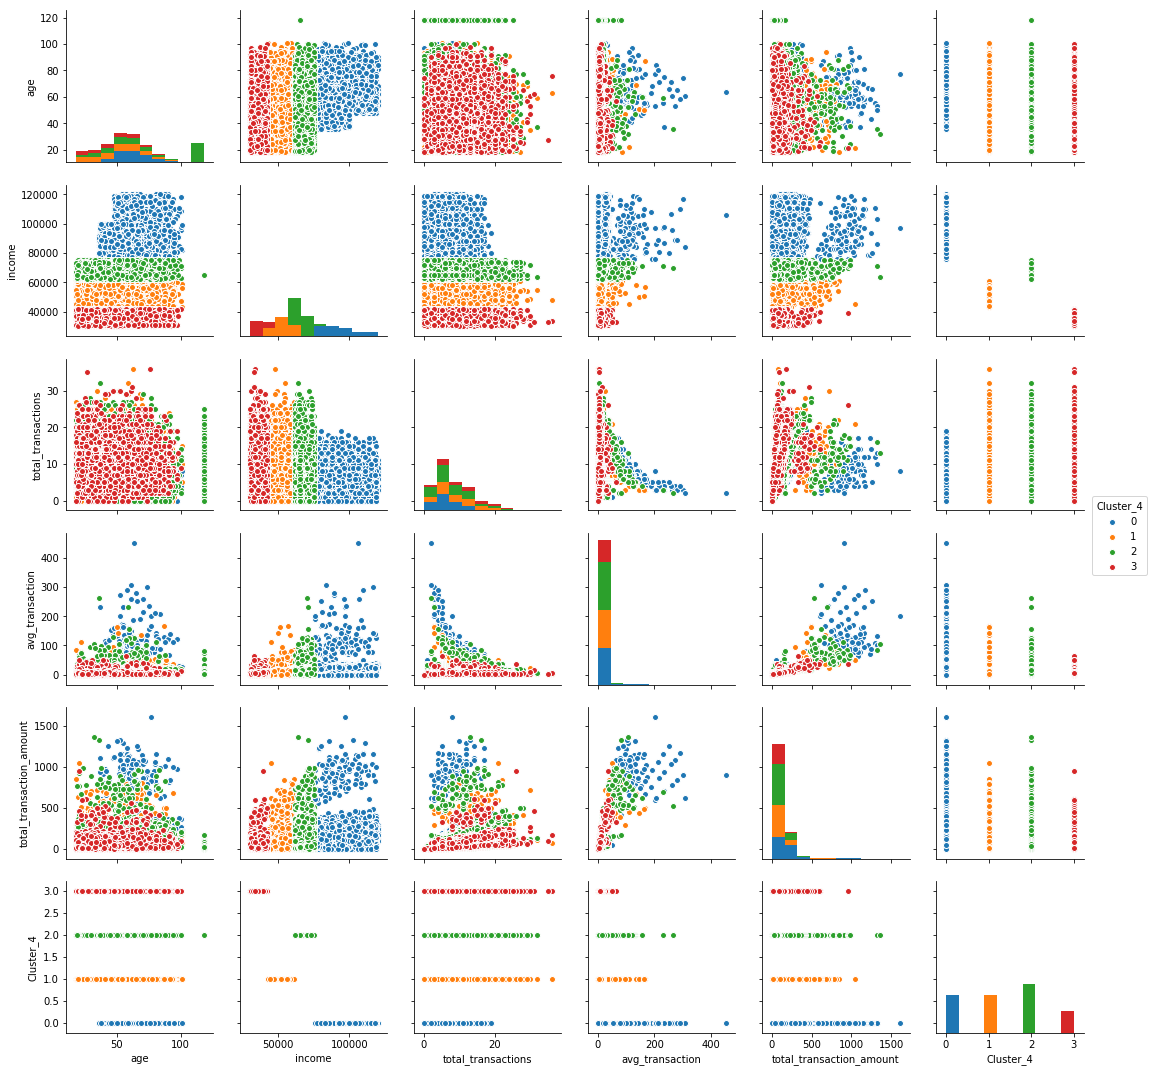

In [62]:
# Personal Demographics
visual_columns = ['age'
                  , 'gender'
                  ,'income'
                  , 'total_transactions'
                  , 'avg_transaction'
                  , 'total_transaction_amount'
                  ,'Cluster_4']

sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Cluster_4');


The next pairplot looks at transactional data and promotional to see which clusters are more responsive to different promotional information.

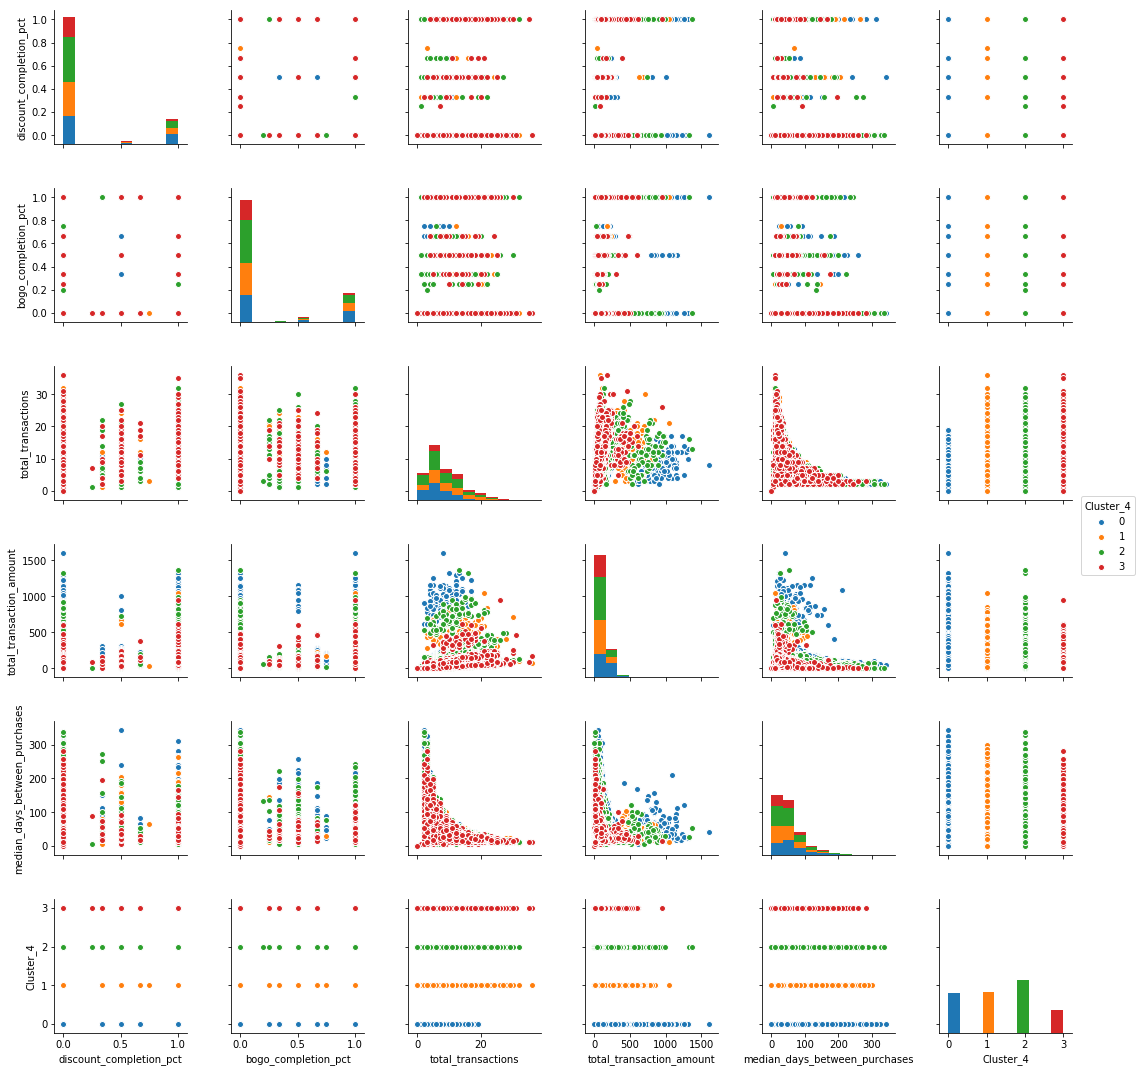

In [63]:
# Transactional Information
visual_columns = ['discount_completion_pct','bogo_completion_pct',
        'total_transactaions', 'total_transaction_amount',
       'median_days_between_purchases','Cluster_4']

sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Cluster_4');

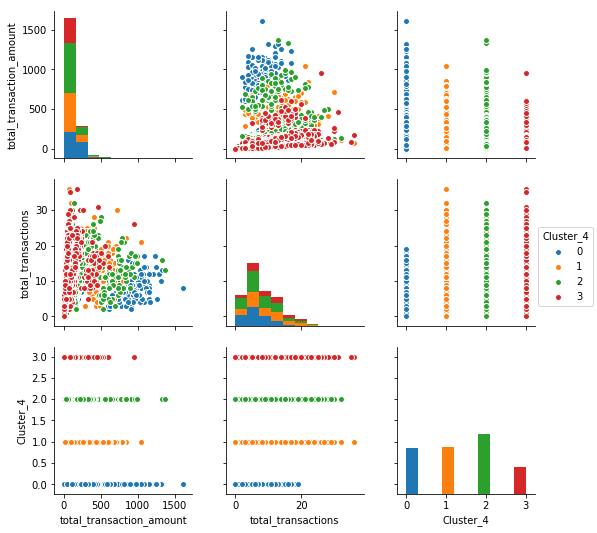

In [64]:
# Look to see cluster trends on total spending and total number of transactions
plt.figure(figsize= (10,8))
sns.pairplot(df_all_customers[['total_transaction_amount','total_transactions','Cluster_4']].fillna(0), hue='Cluster_4');

Looking at total transactions vs total transction amounts, we see that Cluster 0 spends a lot more money than the other clusters, but don't go as often as Cluster 3. Cluster 3 looks like they go more frequently, but don't spend a lot of money overall. Cluster 2, which had the largest population, has a wide variance in this category, they don't really fit into a specific slot. 

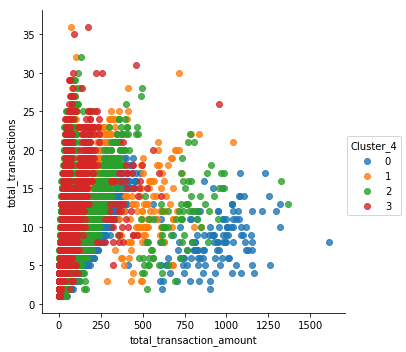

In [116]:
plt.figure(figsize = (20,10))
sns.lmplot(x='total_transaction_amount', y='total_transactions', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False);

When looking at the total nuber of transactions and the freqency of the customer going to Starbucks shops, it looks like all distributions follow the same pattern. The people who come more freqently spend more money and the people who don't come as frequent spend less.

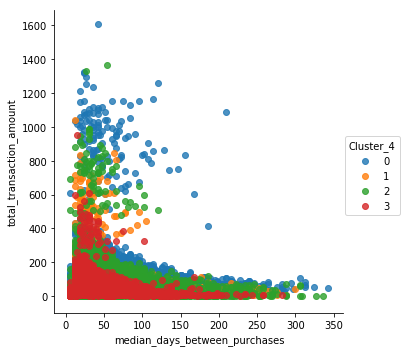

In [115]:
plt.figure(figsize = (20,20));
sns.lmplot(x='median_days_between_purchases', y='total_transaction_amount', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False);

Income has the biggest explanation of the different clusters. As we can see, each cluster has a specific range of income that they make, which in turn would have a big impact on their spending habbits

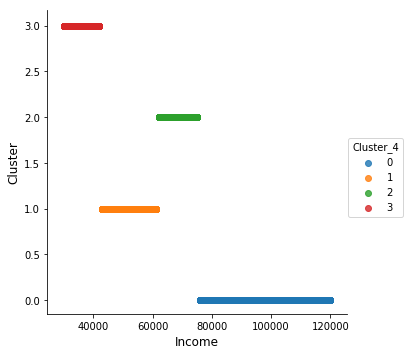

In [117]:
# Cluster and income distirbution
# You can see that this really splits the distribution of income apart
sns.lmplot(x='income', y='Cluster_4', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False)
plt.xlabel('Income', fontsize = 12)
plt.ylabel('Cluster', fontsize = 12)
plt.figure(figsize=(10,8))

Earlier, we spent some time looking to see how the overall poplation reacted to different promotional offers. Let's now see how each cluster responds to those same promotions

In [93]:
clust_offer_aggs = pd.merge(offers_final_df, df_all_customers[['person','Cluster_4']]).groupby(
                            ['Cluster_4','offer_type','difficulty','reward']
                            , as_index = False ).agg({

     'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

clust_offer_aggs = clust_offer_aggs[clust_offer_aggs['offer_type'] != 'informational']
clust_offer_aggs.columns.droplevel(1)
clust_offer_aggs.columns = ['Cluster_4','offer_type','difficulty','reward'
                           , 'CompletedOffers','TotalCompletions','AvgDaysToCompleteOffer','NetReward']

In [94]:
# Now we can see how each cluster responds to the specific offer type
clust_offer_aggs

,Cluster_4,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToCompleteOffer,NetReward
0,0,bogo,5,5,0.511532,865,8.608092,0
1,0,bogo,10,10,0.526596,891,9.077441,0
2,0,discount,7,3,0.602015,478,8.924686,-4
3,0,discount,10,2,0.561009,823,8.712029,-8
4,0,discount,20,5,0.340974,238,8.394958,-15
6,1,bogo,5,5,0.329114,728,8.662088,0
7,1,bogo,10,10,0.201728,537,8.770950,0
8,1,discount,7,3,0.401826,352,8.556818,-4
9,1,discount,10,2,0.262621,489,8.527607,-8
10,1,discount,20,5,0.054434,62,12.096774,-15


In [112]:
def bogo_or_discount(row):
    """
    Checks the overall population average of completed offers for that specifc offer type
    and compares it to the cluster's completion type. Returns the promotional data type that should be offered
    if clustered average success rate is greater than average success rate within a 5% buffer
    
    INPUT - row (full row of the data frame)
    OUTPUT - string (discount or bogo)
    
    """
    offer_type = row['offer_type']
    cluster_val = row['ClusterCompletedOffers']
    avg_val = row['AvgCompletedOffers']
    
    if cluster_val + .05 > avg_val:
        return 'discount'
    else:
        return 'bogo'
        

Our final comparison now takes the Cluster responses to the promotions to the overal population response. If customers are much more responsive to discounted promotions, then you will want to spend more time promoting them discount offers instead of BOGO since you will continue to make more money on your promotions. If they are not responsive to discounts, BOGO will be more apropriate to get them more interested in your product and shorten their times between going to Starbucks

In [113]:
final_comparisons = pd.merge(clust_offer_aggs
         , final_overall_offers_df[['offer_type','difficulty','reward', 'CompletedOffers']]
         , how = 'inner'
         , on = ['offer_type','difficulty','reward']
        ).sort_values(['Cluster_4','offer_type','difficulty','reward'])
final_comparisons.columns = ['Cluster_4', 'offer_type', 'difficulty', 'reward', 'ClusterCompletedOffers',
       'TotalCompletions', 'AvgDaysToCompleteOffer', 'NetReward',
       'AvgCompletedOffers']

final_comparisons['BOGO_or_Discount'] = final_comparisons.apply(bogo_or_discount, axis = 1)
final_comparisons[['Cluster_4', 'offer_type', 'difficulty', 'reward'
                  , 'ClusterCompletedOffers','AvgCompletedOffers','BOGO_or_Discount']
                 ].set_index(['Cluster_4','offer_type'
                            ,'difficulty', 'reward'])

ClusterCompletedOffers  \
Cluster_4 offer_type difficulty reward                           
0         bogo       5          5                     0.511532   
                     10         10                    0.526596   
          discount   7          3                     0.602015   
                     10         2                     0.561009   
                     20         5                     0.340974   
1         bogo       5          5                     0.329114   
                     10         10                    0.201728   
          discount   7          3                     0.401826   
                     10         2                     0.262621   
                     20         5                     0.054434   
2         bogo       5          5                     0.224138   
                     10         10                    0.149921   
          discount   7          3                     0.275216   
                     10         2                     0.202934   
                     20         5                     0.048321   
3         bogo       5          5                     0.219118   
                     10         10                    0.087638   
          discount   7          3                     0.306122   
                     10         2                     0.141766   
                     20         5                     0.013237   

                                        AvgCompletedOffers BOGO_or_Discount  
Cluster_4 offer_type difficulty reward                                       
0         bogo       5          5                 0.308293         discount  
                     10         10                0.217532         discount  
          discount   7          3                 0.383878         discount  
                     10         2                 0.279512         discount  
                     20         5                 0.090034         discount  
1         bogo       5          5                 0.308293         discount  
                     10         10                0.217532         discount  
          discount   7          3                 0.383878         discount  
                     10         2                 0.279512         discount  
                     20         5                 0.090034         discount  
2         bogo       5          5                 0.308293             bogo  
                     10         10                0.217532             bogo  
          discount   7          3                 0.383878             bogo  
                     10         2                 0.279512             bogo  
                     20         5                 0.090034         discount  
3         bogo       5          5                 0.308293             bogo  
                     10         10                0.217532             bogo  
          discount   7          3                 0.383878             bogo  
                     10         2                 0.279512             bogo  
                     20         5                 0.090034             bogo

# Conclusion

These clusters seem to be apropriate for segmenting the customere. It ranges from people who have a good income and will react well to any promotion (cluster 0) all the way to people who have a smaller income and don't react better to the average customer (cluster 3).

One thing that Starbucks should stay away from is offering any kind of "Spend 20 dollars and earn 5 dollars" promotions. Especially to lower income people who take longer to respond, they should be offered BOGO's (specifically the 5 and 5 one) to get them back interested to coming back. Cluster 0 customers are having great responses to the discount promotions, almost as good as the BOGO's. So since they don't make any money back on the BOGO's, they should exclusively give them discounts to keep those customers interested and make money off the promotions as well.

We also see that most of the customers are in clusters are in cluster 0, which seem to be the people who are die hard fans that will not stop at anything to get themselves some coffee. These customers are much more resilent to not needing rewards to keep them engaged, so it doesn't make sense to give them an offer that doesn't slightly benefit the company and the person at once. 